### Install packages

In [ ]:
# install packages - run only 1 time
""""
!pip install InstagramApi
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install -U textblob
!pip install emoji --upgrade
!pip install wordcloud
!pip install nest_asyncio
!pip install --upgrade google-api-python-client
!pip install nltk

!pip install --upgrade gensim
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install smart_open
!pip install cryptography==38.0.4
!pip install pyOpenSSL==22.1.0
!pip install pyldavis
"""

### Load Libraries

In [1]:
# load library
import numpy as np
import pandas as pd
from InstagramAPI import InstagramAPI
from pandas.io.json import json_normalize
from datetime import datetime
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re
from PIL import Image
import urllib
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import string
from textblob import TextBlob
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


Fail to import moviepy. Need only for Video upload.


In [2]:
# configure matplot
%matplotlib inline
sns.set(font_scale=2)

## Load Data

### Youtube

In [ ]:
# Scrape Or Download Comments Using Python Through The Youtube Data API
# Watch the youtube video for explaination
# https://youtu.be/B9uCX2s7y7A


def scrape_comments_with_replies():

    api_key = "" # google API key.

    from googleapiclient.discovery import build
    youtube = build('youtube', 'v3', developerKey=api_key)


    #ID = "UXO6YkDNMOA" # Replace this YouTube video ID with your own.
    ID = "FgCHeh05-cQ" # Replace this YouTube video ID with your own.

    box = [['Name', 'Comment', 'Time', 'Likes']]

    data = youtube.commentThreads().list(part='snippet', videoId=ID, maxResults='100', textFormat="plainText").execute()

    for i in data["items"]:

        name = i["snippet"]['topLevelComment']["snippet"]["authorDisplayName"]
        comment = i["snippet"]['topLevelComment']["snippet"]["textDisplay"]
        published_at = i["snippet"]['topLevelComment']["snippet"]['publishedAt']
        likes = i["snippet"]['topLevelComment']["snippet"]['likeCount']

        box.append([name, comment, published_at, likes])

        totalReplyCount = i["snippet"]['totalReplyCount']

        if totalReplyCount > 0:

            parent = i["snippet"]['topLevelComment']["id"]

            data2 = youtube.comments().list(part='snippet', maxResults='100', parentId=parent,
                                            textFormat="plainText").execute()

            for i in data2["items"]:
                name = i["snippet"]["authorDisplayName"]
                comment = i["snippet"]["textDisplay"]
                published_at = i["snippet"]['publishedAt']
                likes = i["snippet"]['likeCount']

                box.append([name, comment, published_at, likes])

    while ("nextPageToken" in data):

        data = youtube.commentThreads().list(part='snippet', videoId=ID, pageToken=data["nextPageToken"],
                                             maxResults='100', textFormat="plainText").execute()

        for i in data["items"]:
            name = i["snippet"]['topLevelComment']["snippet"]["authorDisplayName"]
            comment = i["snippet"]['topLevelComment']["snippet"]["textDisplay"]
            published_at = i["snippet"]['topLevelComment']["snippet"]['publishedAt']
            likes = i["snippet"]['topLevelComment']["snippet"]['likeCount']

            box.append([name, comment, published_at, likes])

            totalReplyCount = i["snippet"]['totalReplyCount']

            if totalReplyCount > 0:

                parent = i["snippet"]['topLevelComment']["id"]

                data2 = youtube.comments().list(part='snippet', maxResults='100', parentId=parent,
                                                textFormat="plainText").execute()

                for i in data2["items"]:
                    name = i["snippet"]["authorDisplayName"]
                    comment = i["snippet"]["textDisplay"]
                    published_at = i["snippet"]['publishedAt']
                    likes = i["snippet"]['likeCount']

                    box.append([name, comment, published_at, likes])

    df = pd.DataFrame({'Name': [i[0] for i in box], 'Comment': [i[1] for i in box], 'Time': [i[2] for i in box],
                       'Likes': [i[3] for i in box]})

    df.to_csv('youtube-comments.csv', index=False, header=False)

    return 


#scrape_comments_with_replies()

### Instagram

In [ ]:
# Scrape from instagram
def extract_posts(api, userId, userName):
    posts = []
    has_more_posts = True
    max_id = ""

    while has_more_posts:
        api.getUserFeed(userId, maxid=max_id)
        if api.LastJson["more_available"] is not True:
            has_more_posts = False # stop condition
        max_id = api.LastJson.get("next_max_id", "")
        posts.extend(api.LastJson["items"])

    # load data into dataframe and save to csv
    df = pd.DataFrame(posts)
    df.to_csv('instagram-posts_'+userName+'.csv')

    # extract comments
    extract_comments(api, posts, userName)
    # extract likes
    extract_likes(api, posts, userName)

    return posts


# extract comments from instagram posts
def extract_comments(api, posts, userName):
    '''Retrieve all commenters on all posts '''
    comments = []
    for i in range(len(posts)):
        m_id = posts[i]['id']
        api.getMediaComments(m_id)
        comments += [api.LastJson]
        # Include post_id in commenters dict list
        comments[i]['post_id'] = m_id
    # load data into dataframe and save to csv
    df = json_normalize(comments, 'comments', ['post_id'])
    df.to_csv('instagram-comments_'+userName+'.csv')
    return


# extract likes from instagram posts
def extract_likes(api, posts, userName):
    likes = [] 
    for i in range(len(posts)):
        m_id = posts[i]['id']
        api.getMediaLikers(m_id)
        likes += [api.LastJson]
        # post id
        likes[i]['post_id'] = m_id
    df = pd.DataFrame(likes)
    df.to_csv('instagram-likes_'+userName+'.csv')
    return 


# load datas from instagram
def extractInstagram_tocsv(userName):
    #login
    api = InstagramAPI('','') # username and password
    api.login()

    # get gap user
    api.searchUsername(userName)
    userGap = api.LastJson['user']

    # extract posts
    posts = extract_posts(api, userGap['pk'], userName)

#extractInstagram_tocsv('gap')
#extractInstagram_tocsv('gapkids')


In [3]:
# load datas from cvs

# youtube
df_youtube = pd.read_csv('youtube-comments.csv')
df_youtube['origin']='youtube'

# instagram
df_i_posts_gap = pd.read_csv('instagram-posts_gap.csv')
df_i_posts_gapkids = pd.read_csv('instagram-posts_gapkids.csv')
df_i_comments_gap = pd.read_csv('instagram-comments_gap.csv')
df_i_comments_gapkids = pd.read_csv('instagram-comments_gapkids.csv')



## Check Data

In [4]:
df_youtube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1273 non-null   object
 1   Comment  1273 non-null   object
 2   Time     1273 non-null   object
 3   Likes    1273 non-null   int64 
 4   origin   1273 non-null   object
dtypes: int64(1), object(4)
memory usage: 49.9+ KB


In [5]:
df_i_posts_gap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 92 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  223 non-null    int64  
 1   taken_at                                    223 non-null    int64  
 2   pk                                          223 non-null    int64  
 3   id                                          223 non-null    object 
 4   device_timestamp                            223 non-null    int64  
 5   media_type                                  223 non-null    int64  
 6   code                                        223 non-null    object 
 7   client_cache_key                            223 non-null    object 
 8   filter_type                                 223 non-null    int64  
 9   is_unified_video                            223 non-null    bool   
 10  should_request

In [6]:
df_i_posts_gapkids.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 92 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  716 non-null    int64  
 1   taken_at                                    716 non-null    int64  
 2   pk                                          716 non-null    int64  
 3   id                                          716 non-null    object 
 4   device_timestamp                            716 non-null    int64  
 5   media_type                                  716 non-null    int64  
 6   code                                        716 non-null    object 
 7   client_cache_key                            716 non-null    object 
 8   filter_type                                 716 non-null    int64  
 9   is_unified_video                            716 non-null    bool   
 10  should_request

In [7]:
df_i_comments_gap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         2483 non-null   int64  
 1   pk                                 2483 non-null   int64  
 2   user_id                            2483 non-null   int64  
 3   text                               2483 non-null   object 
 4   type                               2483 non-null   int64  
 5   created_at                         2483 non-null   int64  
 6   created_at_utc                     2483 non-null   int64  
 7   content_type                       2483 non-null   object 
 8   status                             2483 non-null   object 
 9   bit_flags                          2483 non-null   int64  
 10  did_report_as_spam                 2483 non-null   bool   
 11  share_enabled                      2483 non-null   bool 

In [8]:
df_i_comments_gapkids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8550 entries, 0 to 8549
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         8550 non-null   int64  
 1   pk                                 8550 non-null   int64  
 2   user_id                            8550 non-null   int64  
 3   text                               8550 non-null   object 
 4   type                               8550 non-null   int64  
 5   created_at                         8550 non-null   int64  
 6   created_at_utc                     8550 non-null   int64  
 7   content_type                       8550 non-null   object 
 8   status                             8550 non-null   object 
 9   bit_flags                          8550 non-null   int64  
 10  did_report_as_spam                 8550 non-null   bool   
 11  share_enabled                      8550 non-null   bool 

## Data Preparation

In [9]:
# gap

# correct column date
df_i_comments_gap['created_at'] = df_i_comments_gap['created_at'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%dT%H:%M:%SZ'))

# correct dataframe with columns that we will use
df_i_comments_gap = df_i_comments_gap[['user.username', 'text', 'created_at','comment_like_count']]
df_i_comments_gap['origin']='instagram-gap'

# rename columns name to the same of youtube comments
df_i_comments_gap = df_i_comments_gap.rename(columns={'user.username': 'Name','text':'Comment','created_at':'Time','comment_like_count':'Likes'})

In [10]:
#gapkids

# correct column date
df_i_comments_gapkids['created_at'] = df_i_comments_gapkids['created_at'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%dT%H:%M:%SZ'))

# correct dataframe with columns that we will use
df_i_comments_gapkids = df_i_comments_gapkids[['user.username', 'text', 'created_at','comment_like_count']]
df_i_comments_gapkids['origin']='instagram-gapkidds'

# rename columns name to the same of youtube comments
df_i_comments_gapkids = df_i_comments_gapkids.rename(columns={'user.username': 'Name','text':'Comment','created_at':'Time','comment_like_count':'Likes'})

In [11]:
# join the data from youtube comments and instagram comments
df_comments = df_youtube
df_comments = df_comments.append(df_i_comments_gap)
df_comments = df_comments.append(df_i_comments_gapkids)


In [12]:
df_comments.groupby('origin')['origin'].count()

origin
instagram-gap         2483
instagram-gapkidds    8550
youtube               1273
Name: origin, dtype: int64

In [13]:
# Cleaning up the text 
def process_text(text, stem=False): #clean text

    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    text = re.sub(r'\b\w{1}\b', '', text) #remove word with one carcater
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text)) # remove @mentions
    text = re.sub(r'#', '',  str(text)) # remove the '#' symbol
    text = re.sub(r'RT[\s]+', '',  str(text)) # remove RT
    text = re.sub(r'https?\/\/S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'http\S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'www\S+', '',  str(text)) # remove the www
    text = re.sub(r'pic+', '',  str(text)) # remove the pic
    text = re.sub(r'com', '',  str(text)) # remove the pic
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

re.compile('<title>(.*)</title>')


re.compile(r'<title>(.*)</title>', re.UNICODE)

In [14]:
# download the set of stop words the first time
nltk.download('stopwords')

# Load stop words
stop_words = stopwords.words('english')
stop_words.extend(['wa'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marimarson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# create columns with comment cleaned
df_comments['cleaned_comments']=df_comments['Comment'].apply(lambda x: process_text(x))
# remove rows withouy value in cleaned comments
df_comments = df_comments.drop(df_comments[df_comments['cleaned_comments'] ==''].index)

### Word Cloud

In [16]:
# WordCloud
def wCloud(origin):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
    
    if origin != '':
        df_w = df_comments[(df_comments['origin']==origin)]
    else:
        df_w = df_comments[(df_comments['origin']!='youtube')]

    # iterate through the csv file 
    for val in df_w.cleaned_comments: 
        
        # typecaste each val to string 
        val = str(val) 
    
        # split the value 
        tokens = val.split() 
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 1000, height = 800, 
                    background_color='white', colormap='Set2', 
                    collocations=False, 
                    stopwords = stopwords, 
                    min_font_size = 12).generate(comment_words) 
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    print(origin)
    plt.show() 
    return

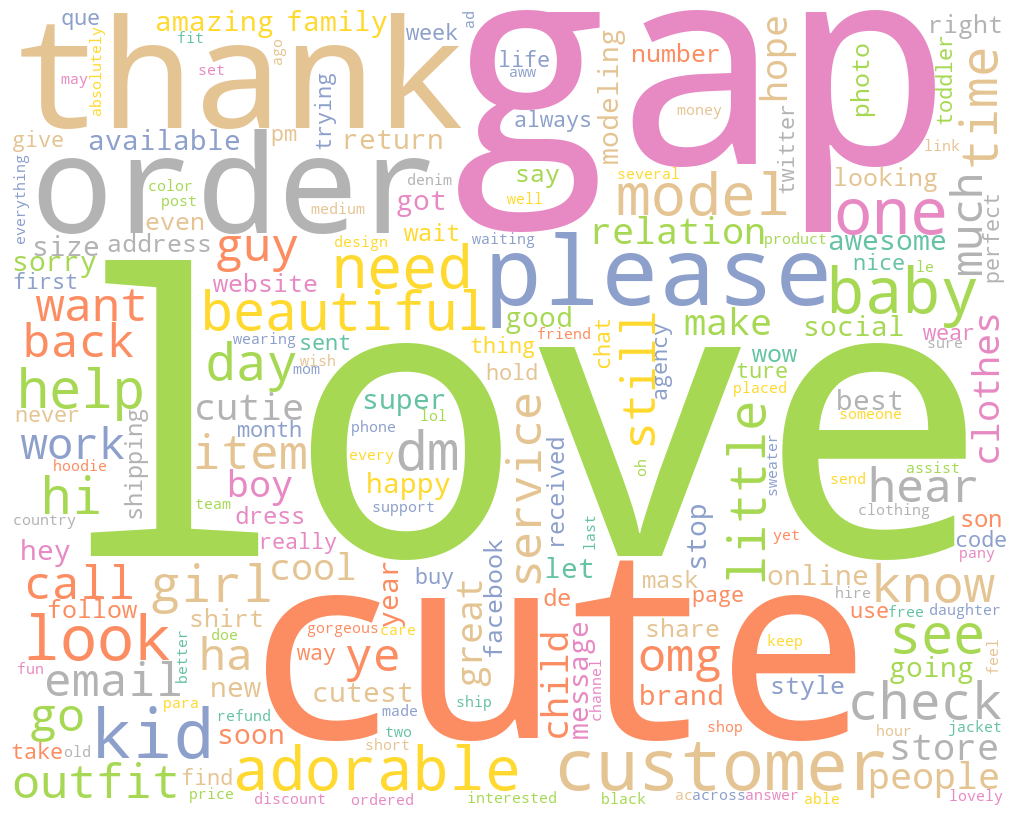

In [17]:
# wordcloud gap + gapkids
wCloud('')

instagram-gap


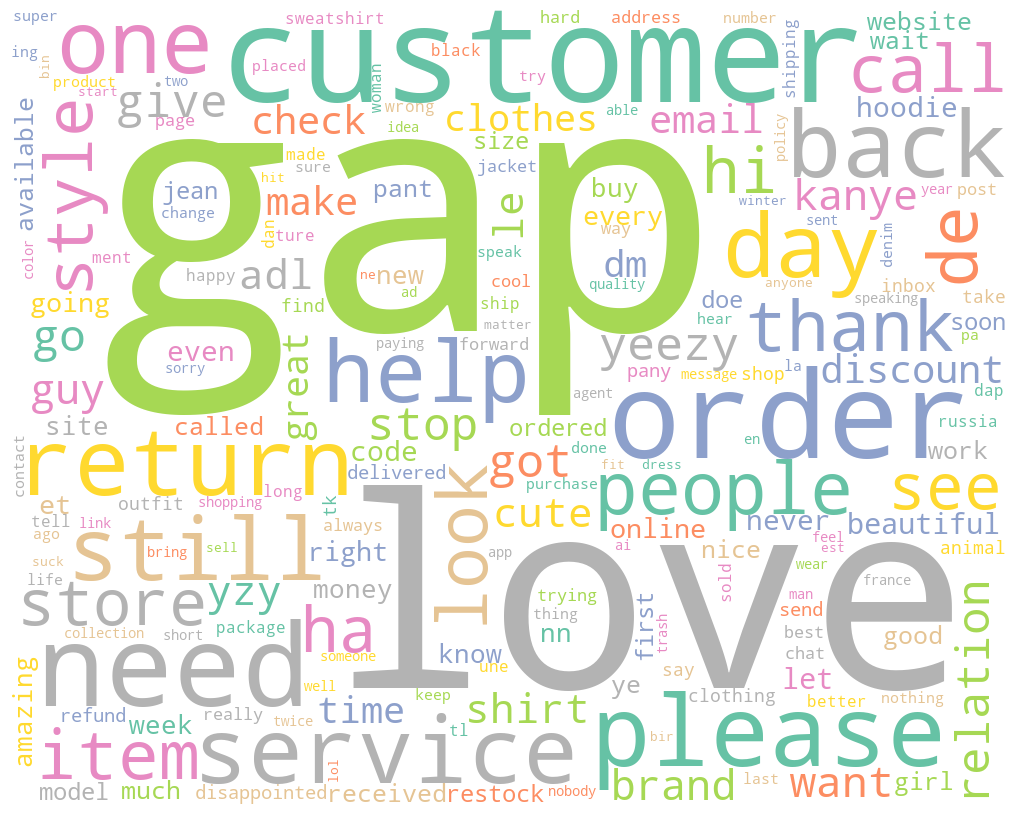

In [18]:
# wordcloud gap
wCloud('instagram-gap')

instagram-gapkidds


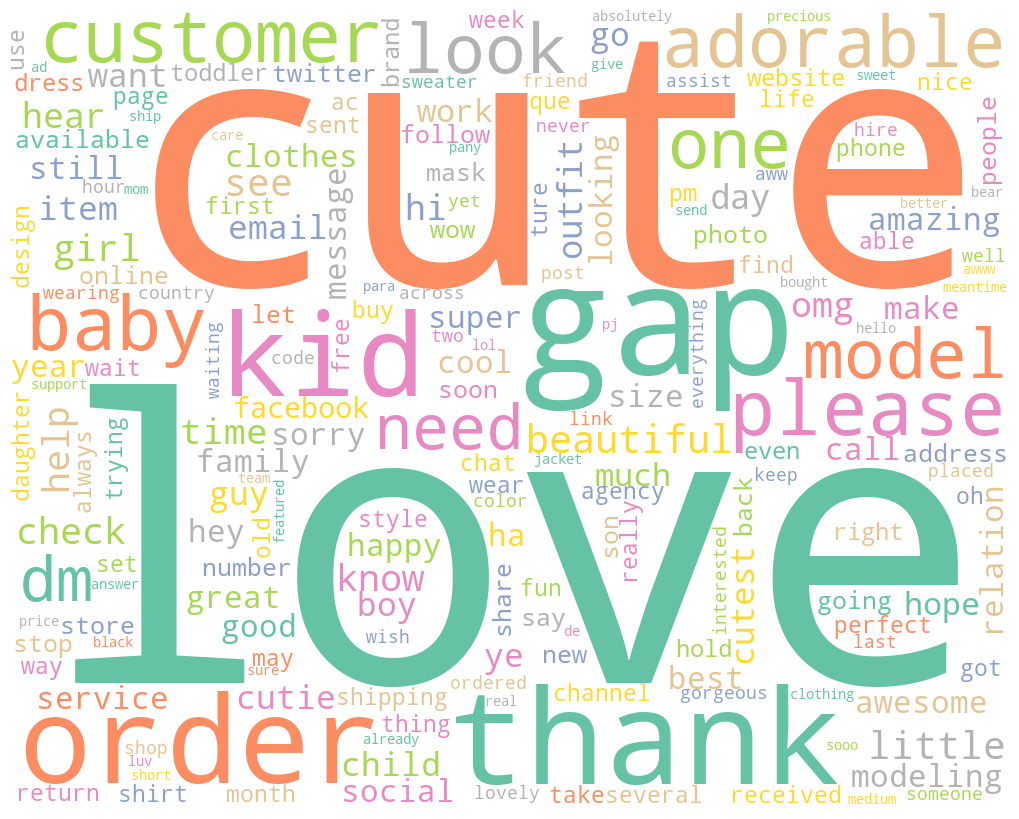

In [19]:
# wordcloud gap
wCloud('instagram-gapkidds')

youtube


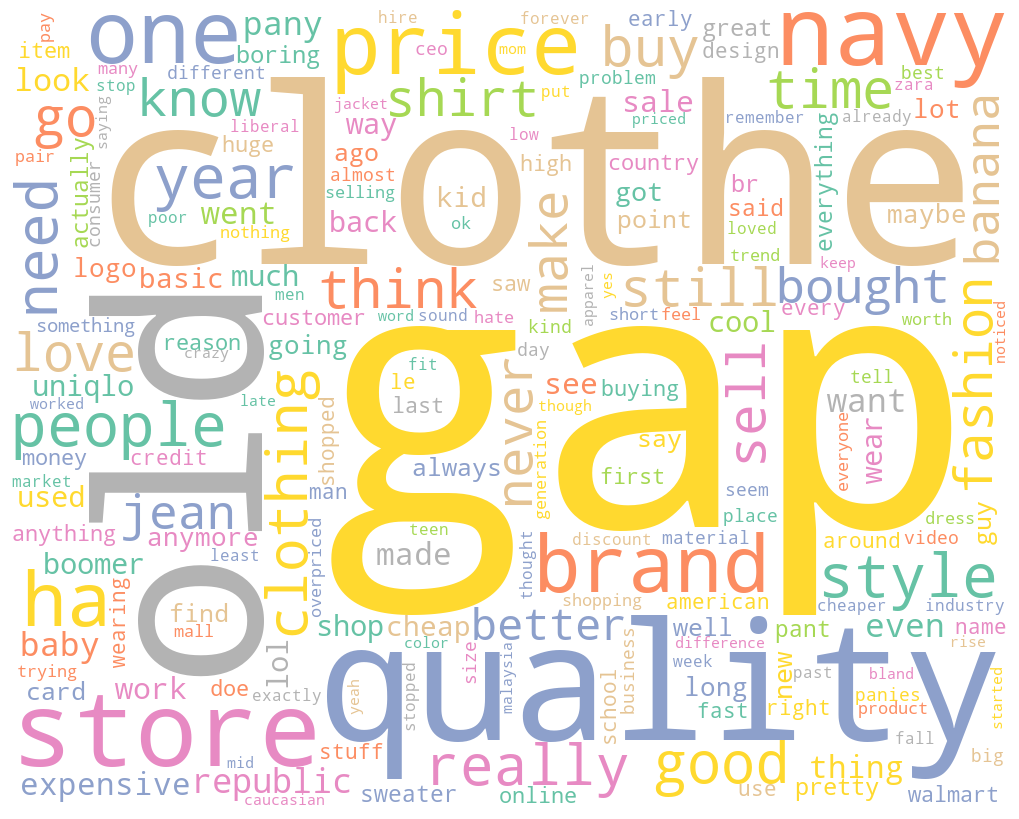

In [20]:
# wordcloud gap + gapkids
wCloud('youtube')

In [21]:
# top words

def wordList(cleaned_comments):
    words_list = '' 
    
    # iterate through the csv file 
    for val in cleaned_comments: 
        
        # typecaste each val to string 
        val = str(val) 
    
        # split the value 
        tokens = val.split() 
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        
        words_list += " ".join(tokens)+" "
    
    return words_list

def topWord(word_list):
    data = {'word': [], 'count': []}
    dfWords = pd.DataFrame(data)

    # convert the text into a list of words
    words = word_list.split()

    # use the Counter class to count the frequency of each word
    word_count = Counter(words)

    # print the frequency of each word
    for word, count in word_count.items():
        new_data = {'word': [word], 'count': [count]}
        dfWords = dfWords.append(pd.DataFrame(new_data), ignore_index=True)

    dfWords = dfWords.sort_values('count', ascending=False)
    return dfWords

In [22]:
#top 10 words youtube
df_temp = topWord(wordList(df_comments[(df_comments['origin']=='youtube')]['cleaned_comments']))
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())
df_temp.head(10)



words:  2057
total:  6463.0


,word,count
17,gap,258.0
45,clothes,86.0
114,old,74.0
314,quality,71.0
166,store,69.0
79,like,62.0
115,navy,61.0
121,one,49.0
215,price,46.0
1,brand,40.0


In [23]:
#top 10 words instagram gap
df_temp = topWord(wordList(df_comments[(df_comments['origin']=='instagram-gap')]['cleaned_comments']))
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())
df_temp.head(10)

words:  2370
total:  6627.0


,word,count
30,gap,161.0
292,love,84.0
319,get,83.0
327,customer,64.0
337,order,51.0
360,need,45.0
393,please,44.0
466,return,39.0
40,back,38.0
328,service,38.0


In [24]:
#top 10 words instagram gapkids
df_temp = topWord(wordList(df_comments[(df_comments['origin']=='instagram-gapkidds')]['cleaned_comments']))
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())
df_temp.head(10)


words:  4291
total:  24639.0


,word,count
25,love,667.0
22,cute,547.0
26,gap,419.0
476,order,246.0
98,kid,217.0
165,get,216.0
152,please,195.0
55,baby,188.0
159,thank,180.0
299,customer,174.0


In [25]:
#top 10 words instagram gap + gapkids
df_temp = topWord(wordList(df_comments[(df_comments['origin']!='youtube')]['cleaned_comments']))
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())
df_temp.head(10)

words:  5411
total:  31266.0


,word,count
292,love,751.0
30,gap,580.0
273,cute,566.0
319,get,299.0
337,order,297.0
393,please,239.0
327,customer,238.0
461,kid,222.0
335,one,195.0
59,thank,193.0


In [26]:
#top 10 words all
df_temp = topWord(wordList(df_comments['cleaned_comments']))
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())
df_temp.head(10)


words:  6255
total:  37729.0


,word,count
17,gap,838.0
113,love,778.0
326,cute,571.0
391,get,323.0
476,order,299.0
251,customer,249.0
121,one,244.0
425,please,244.0
117,kid,239.0
79,like,222.0


In [27]:
#total words 
df_temp = topWord(wordList(df_comments[(df_comments['origin']=='youtube')]['cleaned_comments']))
print('youtube')
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())

df_temp = topWord(wordList(df_comments[(df_comments['origin']=='instagram-gapkidds')]['cleaned_comments']))
print('instagram GAP KIDS')
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())

df_temp = topWord(wordList(df_comments[(df_comments['origin']=='instagram-gap')]['cleaned_comments']))
print('instagram GAP')
print('words: ',df_temp['word'].count())
print('total: ',df_temp['count'].sum())


youtube
words:  2057
total:  6463.0
instagram GAP KIDS
words:  4291
total:  24639.0
instagram GAP
words:  2370
total:  6627.0


In [28]:
# subjectivity and polarity
def getSubjectivity(text):
    return TextBlob( str(text)).sentiment.subjectivity

def getPolarity(text):
    return TextBlob( str(text)).sentiment.polarity


In [29]:
df_comments.dropna(subset=['cleaned_comments'], inplace = True)
df_comments.reset_index(drop=True, inplace=True)
df_comments['Subjectivity'] = df_comments['cleaned_comments'].apply(getSubjectivity)
df_comments['Polarity'] = df_comments['cleaned_comments'].apply(getPolarity)
df_comments.head(10)

,Name,Comment,Time,Likes,origin,cleaned_comments,Subjectivity,Polarity
0,Arya Shar,THER BRAND JEANS AND DENIM JACKETS WEAR GREAT ...,2022-12-14T16:31:07Z,1.0,youtube,ther brand jean denim jacket wear great heavy ...,0.625000,0.300000
1,TANUJ AADITYA,The weapons with which the capitalist felled f...,2022-11-25T05:11:14Z,0.0,youtube,weapon capitalist felled feudalism ground turn...,0.000000,0.000000
2,OneJacket,The Gap warehouses are toxic unrealistic envir...,2022-10-09T11:27:57Z,0.0,youtube,gap warehouse toxic unrealistic environment ce...,0.845238,-0.089286
3,JPLSJP,The gap and Nike are sweat shops!!!!,2022-08-12T06:11:09Z,0.0,youtube,gap nike sweat shop,0.000000,0.000000
4,huntressvideos,Yes I loved and owned the hoodies but also rea...,2022-08-06T16:35:25Z,0.0,youtube,yes loved owned hoodies also really great jean...,0.766667,0.766667
5,Cosmo,When I visit the Gap (US/North America) websit...,2022-07-20T15:04:13Z,1.0,youtube,visit gap north america website look model see...,0.283333,0.088095
6,Michael Izzo,...and rise again thanks to mr west,2022-05-18T08:34:49Z,0.0,youtube,rise thanks mr west,0.200000,0.200000
7,Jonathan Collins,Worked at the GAP the summer after I graduated...,2022-03-17T11:20:19Z,0.0,youtube,worked gap summer graduated college fun job st...,0.625000,-0.050000
8,Sheen Delute,them got amhunation drobewar sales late 2000 f...,2022-02-08T13:41:30Z,0.0,youtube,got amhunation drobewar sale late king english,0.300000,-0.150000
9,Hao,gap more like crap,2021-12-13T05:46:49Z,0.0,youtube,gap like crap,0.800000,-0.800000


In [30]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def get_Polarity_Analysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
def get_Subjectivity_Analysis(score):
    if score >  0:
      return 'Opinion'
    else:
      return 'Fact'

df_comments['Analysis_Polarity'] = df_comments['Polarity'].apply(get_Polarity_Analysis)

df_comments['Analysis_Subjectivity'] = df_comments['Subjectivity'].apply(get_Subjectivity_Analysis)

In [31]:
df_comments.to_csv('comments.csv')

In [32]:
print('min date: ', df_comments['Time'].min())
print('max date: ', df_comments['Time'].max())


min date:  2019-02-25T15:51:34Z
max date:  2023-04-08T16:08:15Z


In [33]:

def plot_SentimentAnalysis(df_sent, detail):
    plt.figure(figsize=(15,10)) 
    plt.scatter(df_sent['Polarity'], df_sent['Subjectivity'], c=df_sent['Polarity'], s=100, cmap='RdYlGn') 
    plt.xlim(-1.1, 1.1)
    plt.ylim(-0.1, 1.1) 
    plt.title('Sentiment Analysis '+detail) 
    plt.xlabel('Polarity') 
    plt.ylabel('Subjectivity') 
    plt.show()

def plot_PolatiryAnalisys(df_sent, detail):
    # Plotting and visualizing the counts - polarity
    plt.figure(figsize=(15,10)) 
    plt.title('Polarity Sentiment Analysis '+detail)
    plt.xlabel('Sentiment')
    plt.ylabel('Counts')
    df_sent['Analysis_Polarity'].value_counts().plot(kind = 'bar')
    plt.show()

# Plotting and visualizing the counts - subjectivity
def plot_SubjectivityAnalysis(df_sent, detail):
    plt.figure(figsize=(15,10)) 
    plt.title('Subjectivity Sentiment Analysis '+detail)
    plt.xlabel('Sentiment')
    plt.ylabel('Counts')
    df_sent['Analysis_Subjectivity'].value_counts().plot(kind = 'bar')
    plt.show()


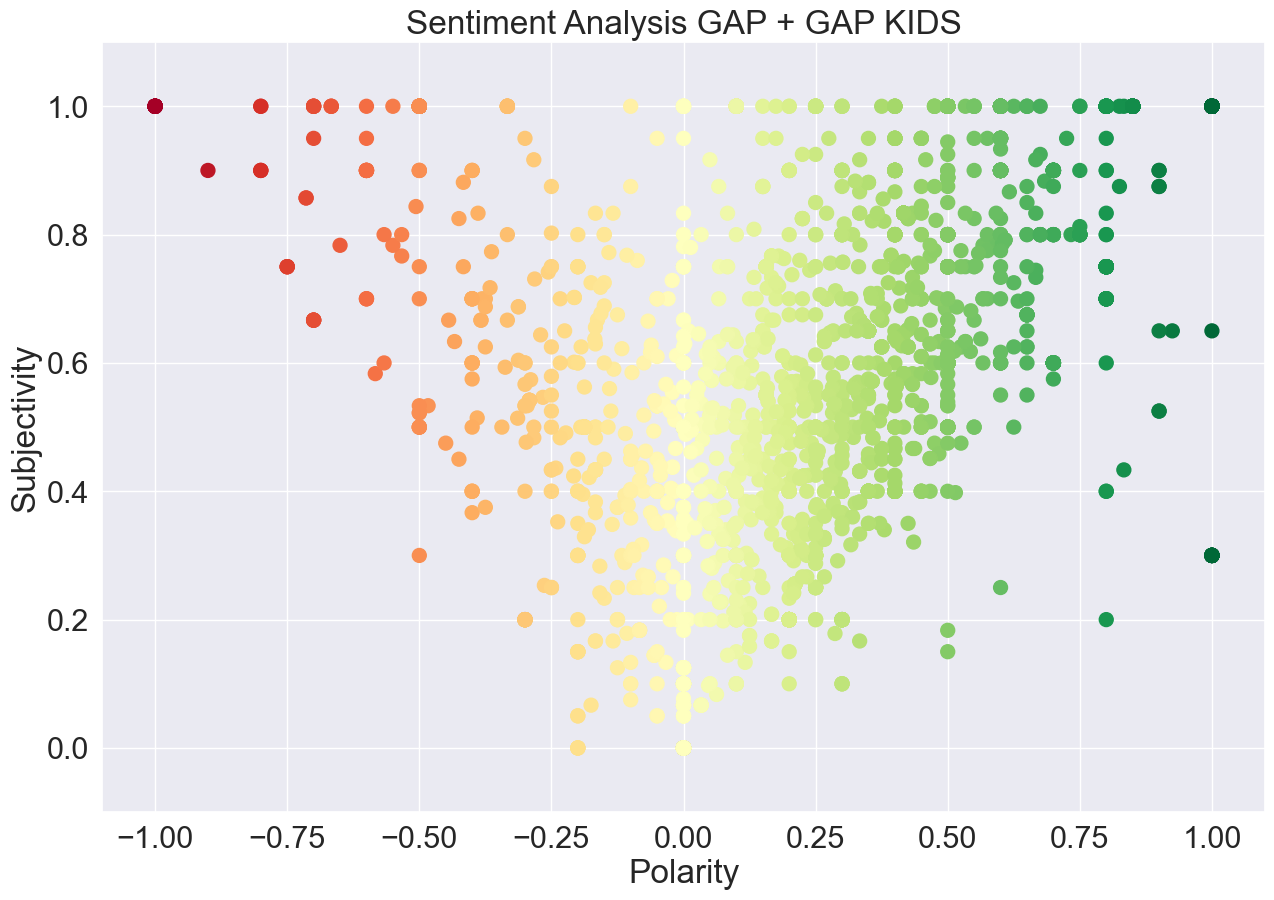

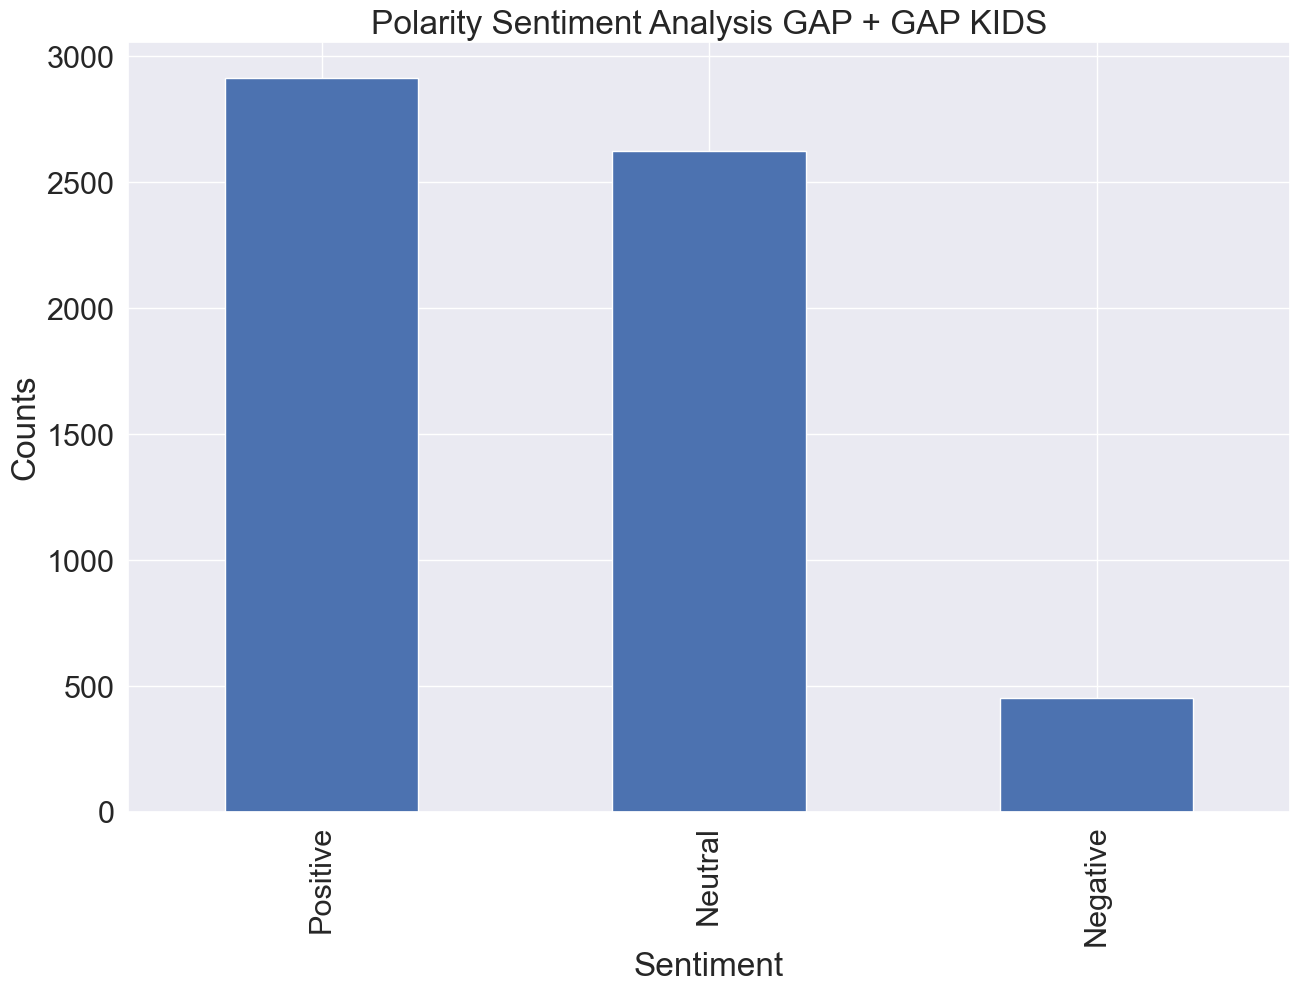

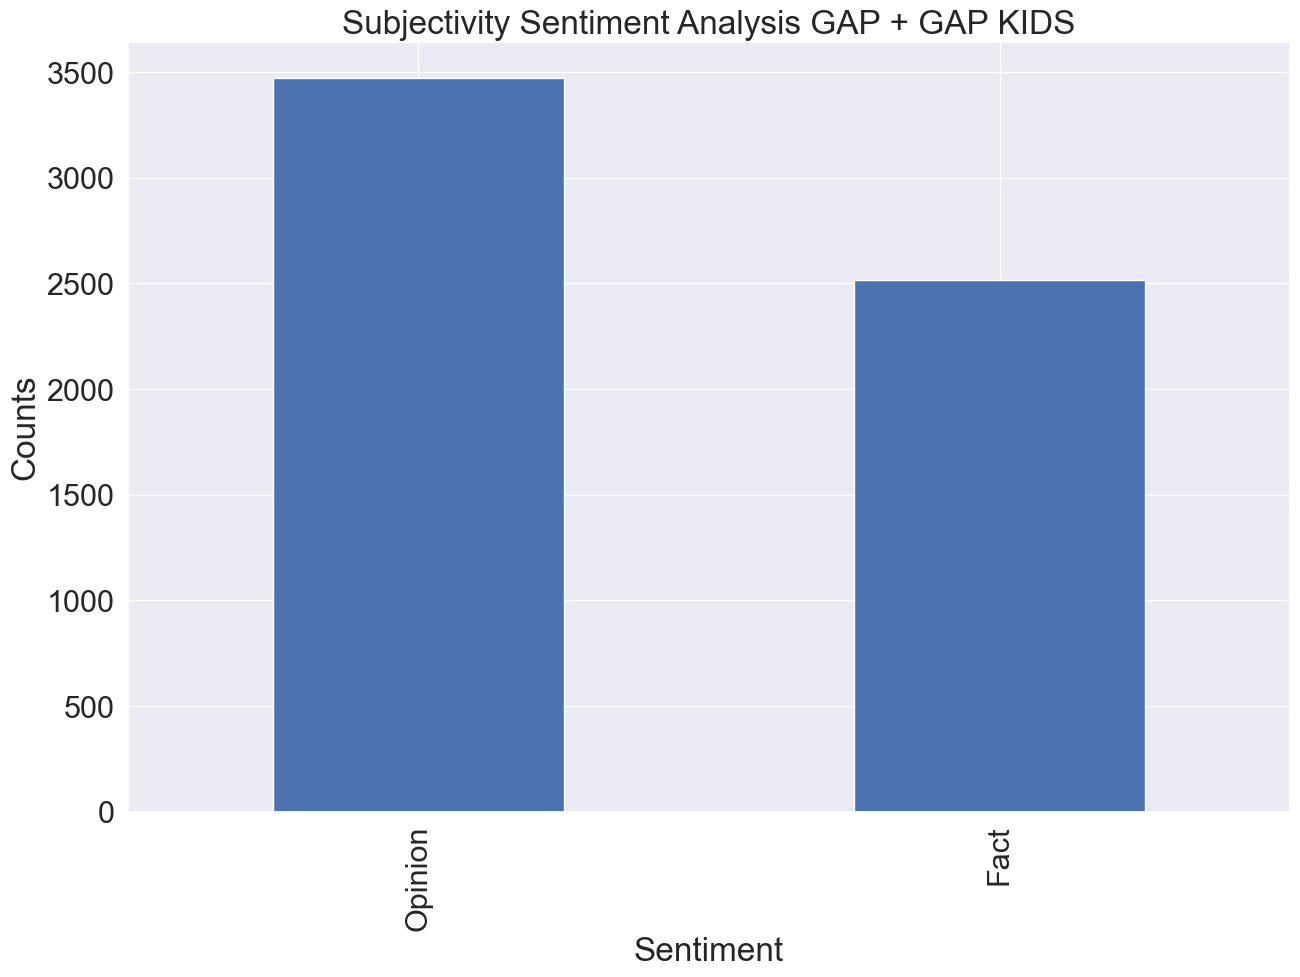

In [34]:
# gap + gapkids
df_sent = df_comments[(df_comments['origin']!='youtube')]
plot_SentimentAnalysis(df_sent, 'GAP + GAP KIDS')
plot_PolatiryAnalisys(df_sent, 'GAP + GAP KIDS')
plot_SubjectivityAnalysis(df_sent, 'GAP + GAP KIDS')

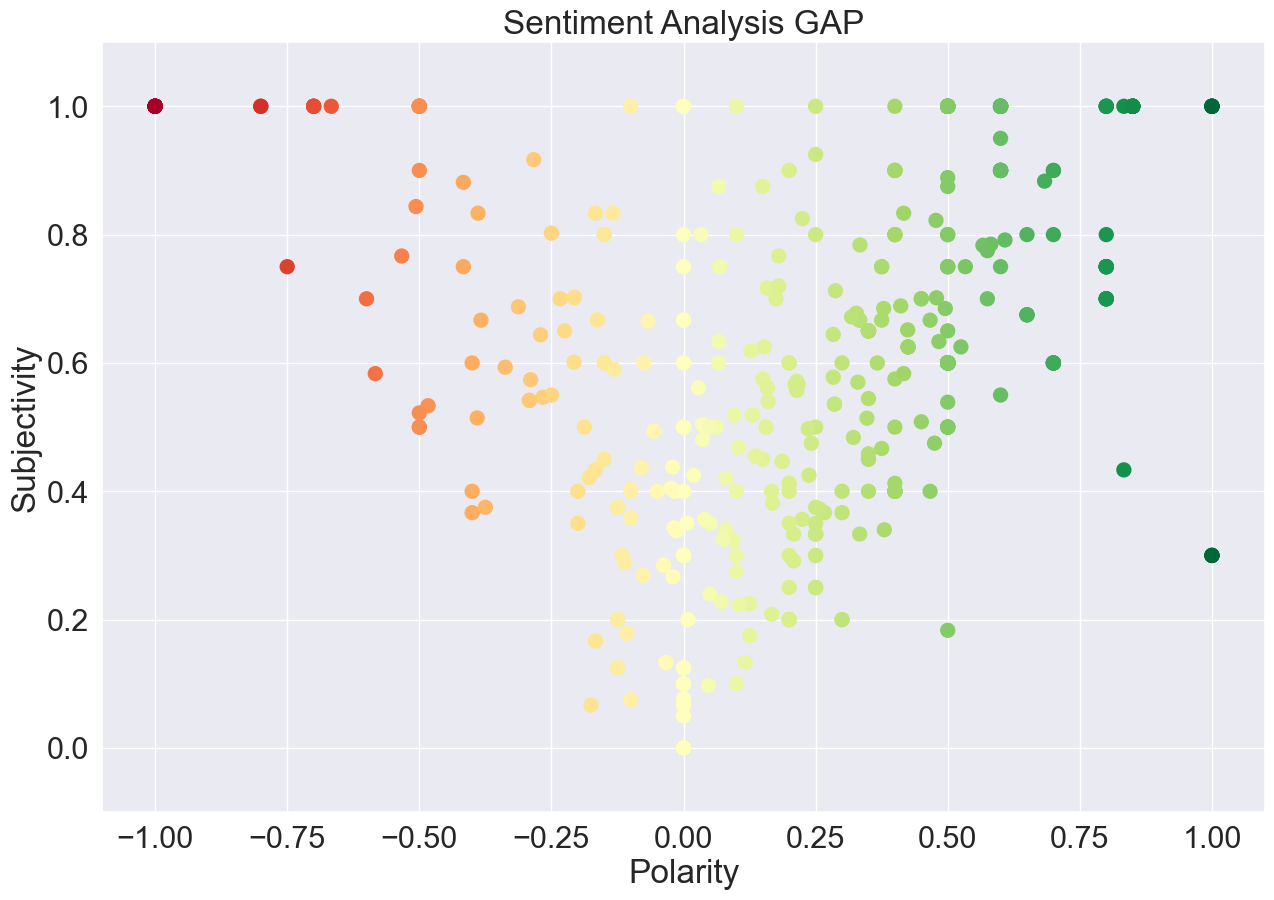

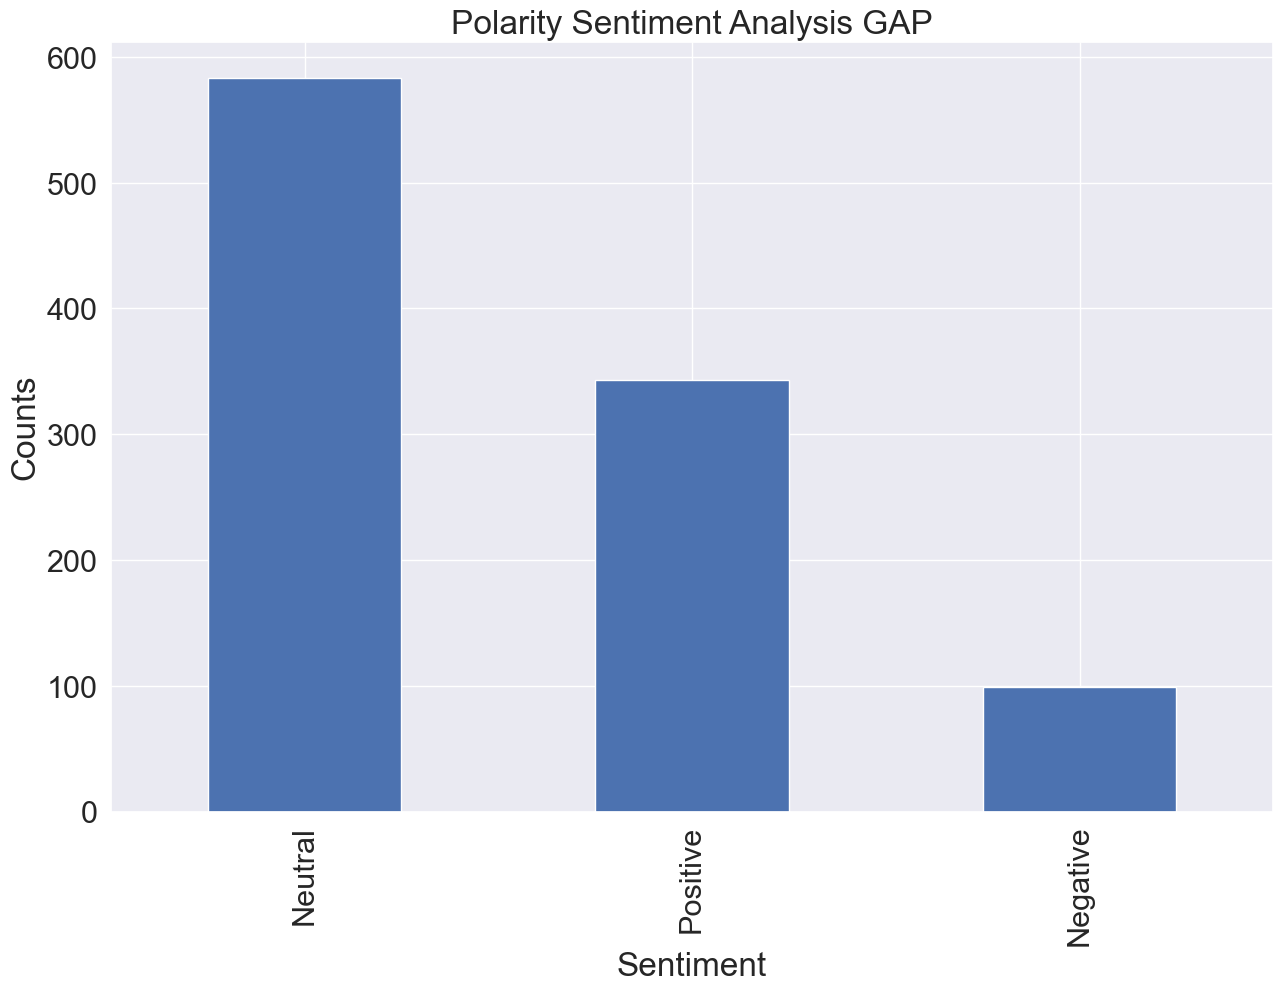

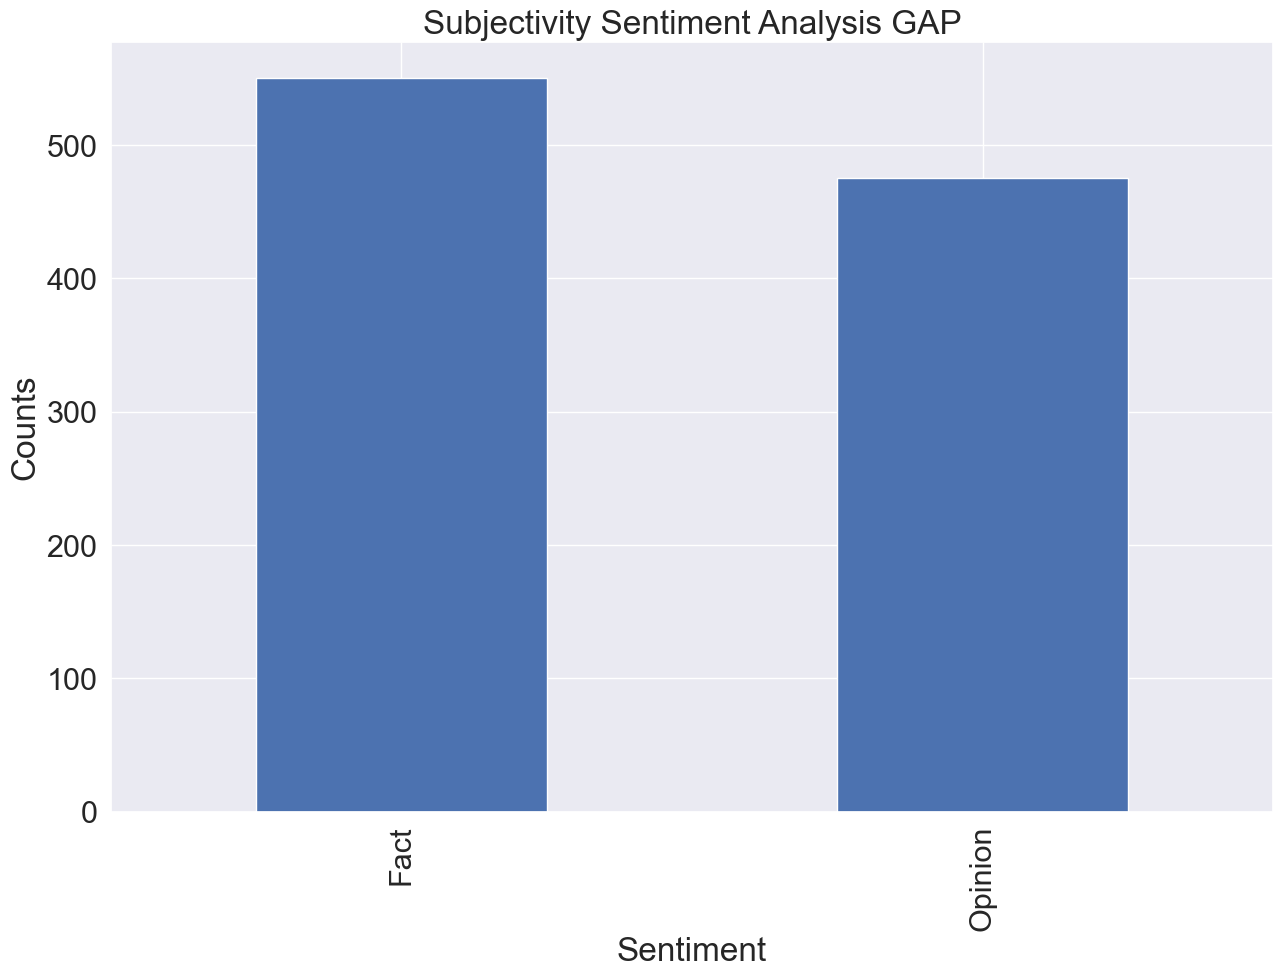

In [35]:
# gap
df_sent = df_comments[(df_comments['origin']=='instagram-gap')]
plot_SentimentAnalysis(df_sent, 'GAP')
plot_PolatiryAnalisys(df_sent, 'GAP')
plot_SubjectivityAnalysis(df_sent, 'GAP')


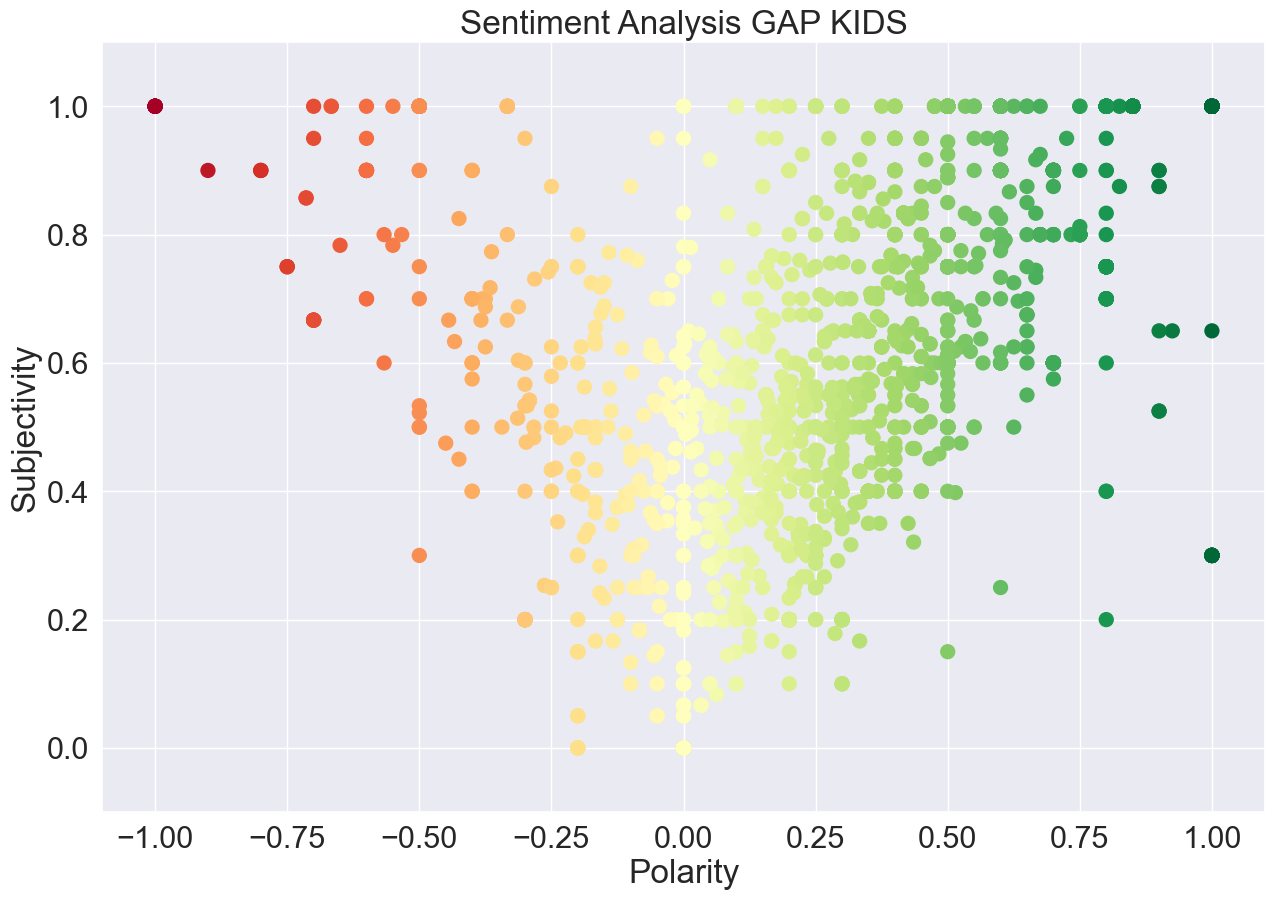

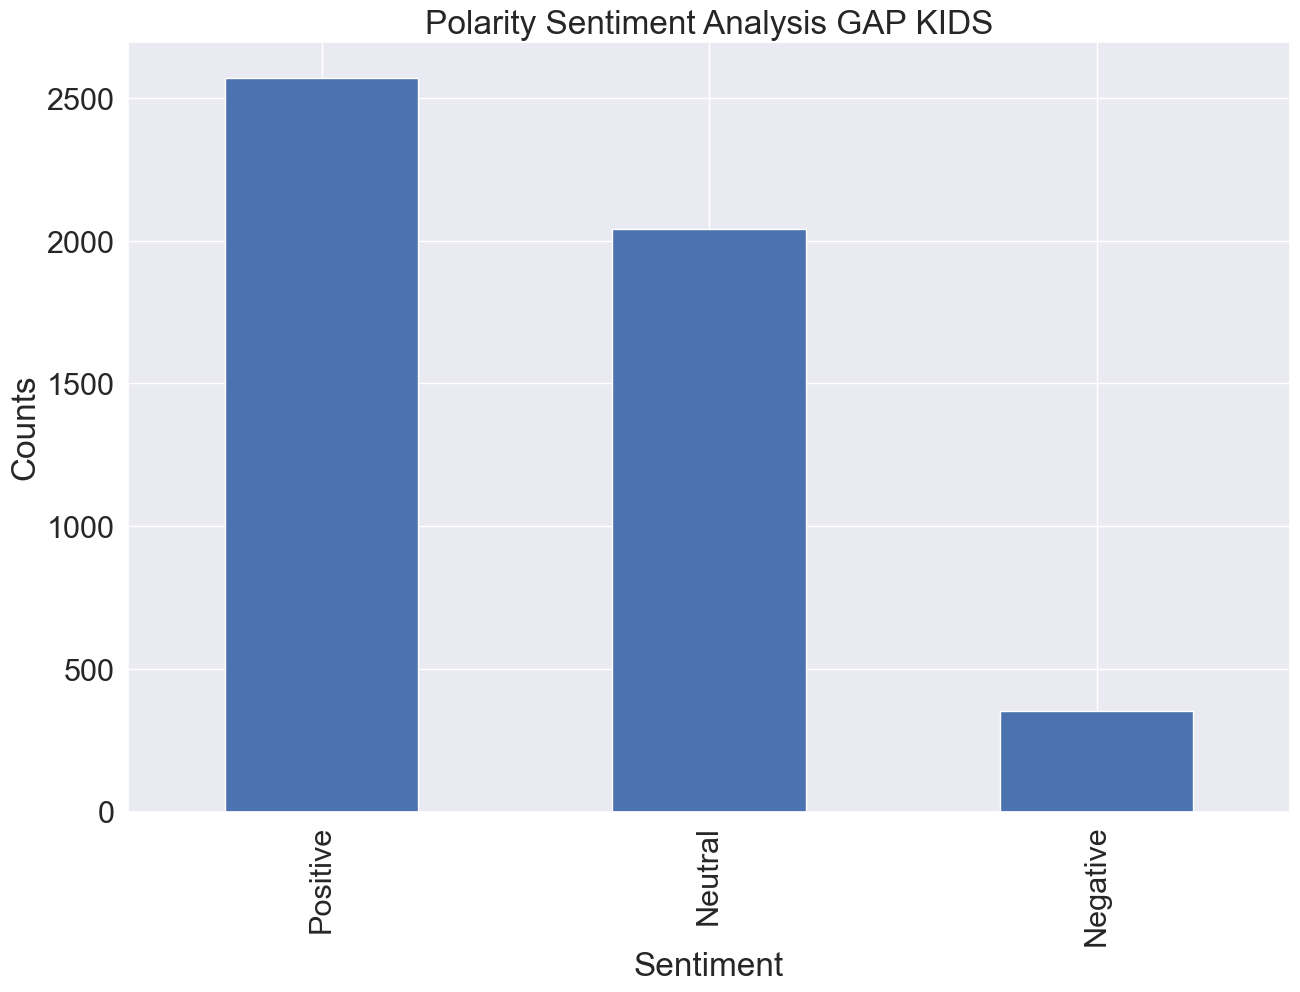

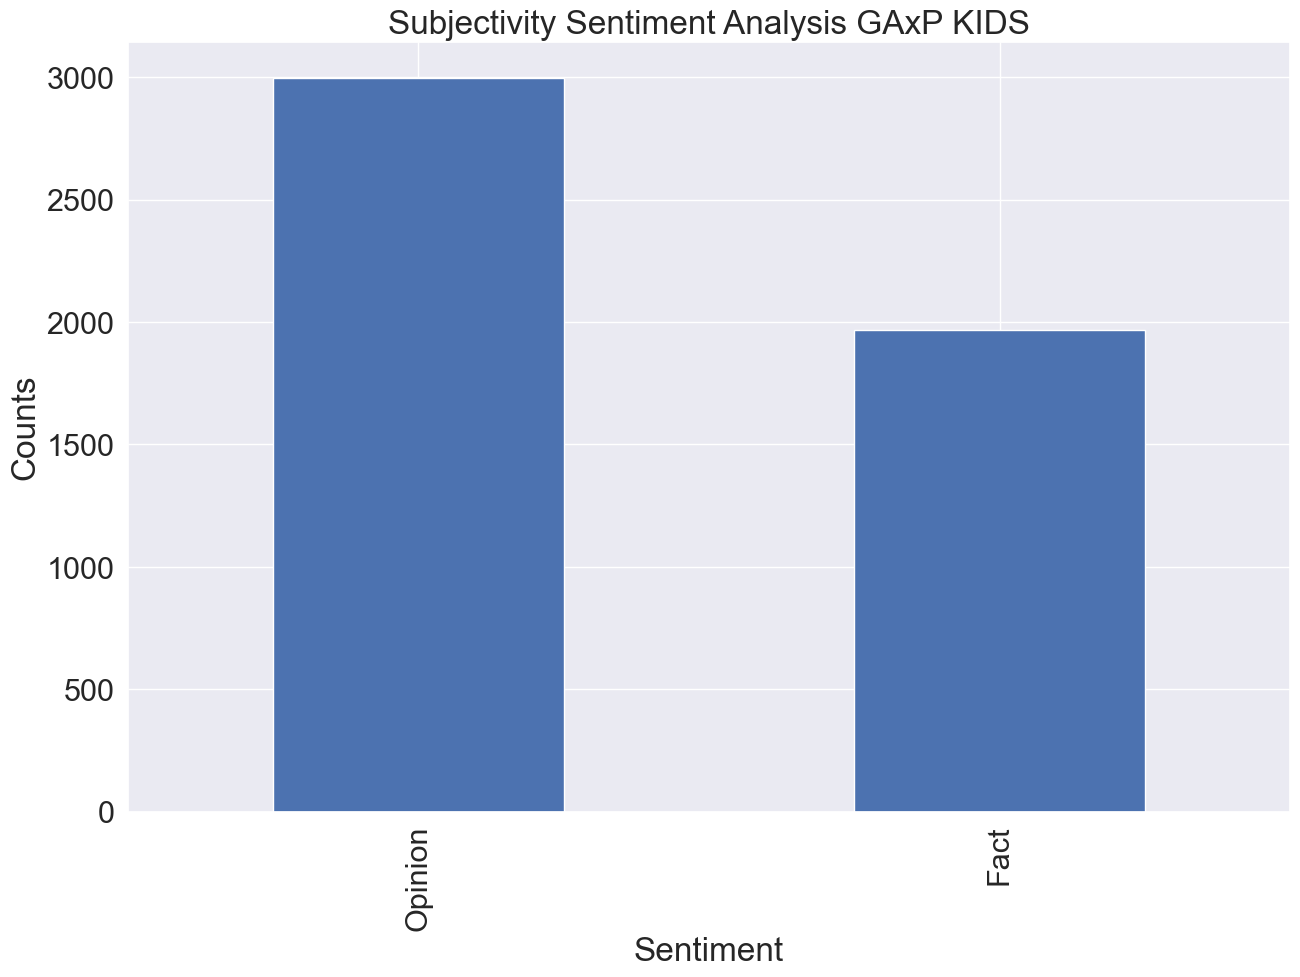

In [36]:
# gapkids
df_sent = df_comments[(df_comments['origin']=='instagram-gapkidds')]
plot_SentimentAnalysis(df_sent, 'GAP KIDS')
plot_PolatiryAnalisys(df_sent, 'GAP KIDS')
plot_SubjectivityAnalysis(df_sent, 'GAxP KIDS')


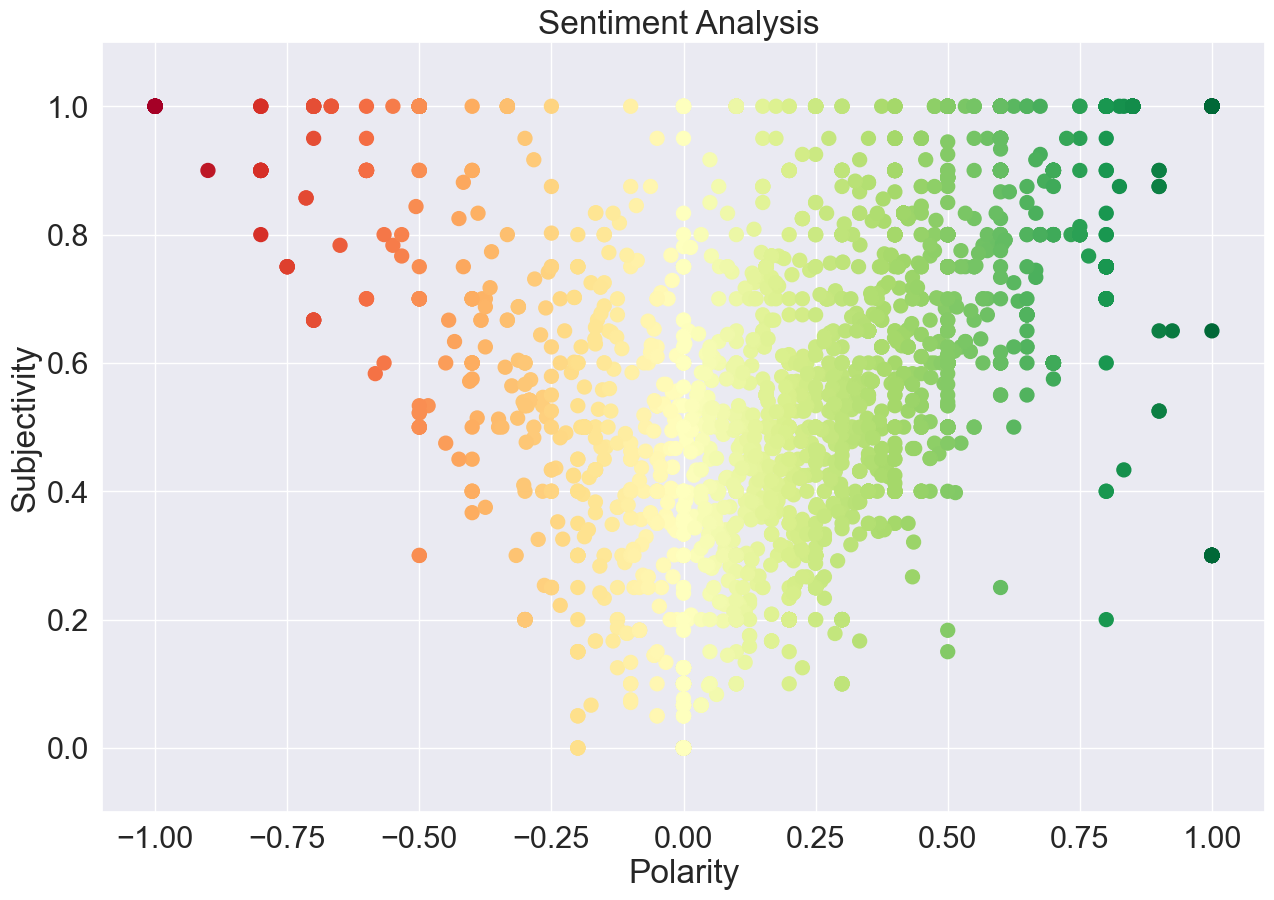

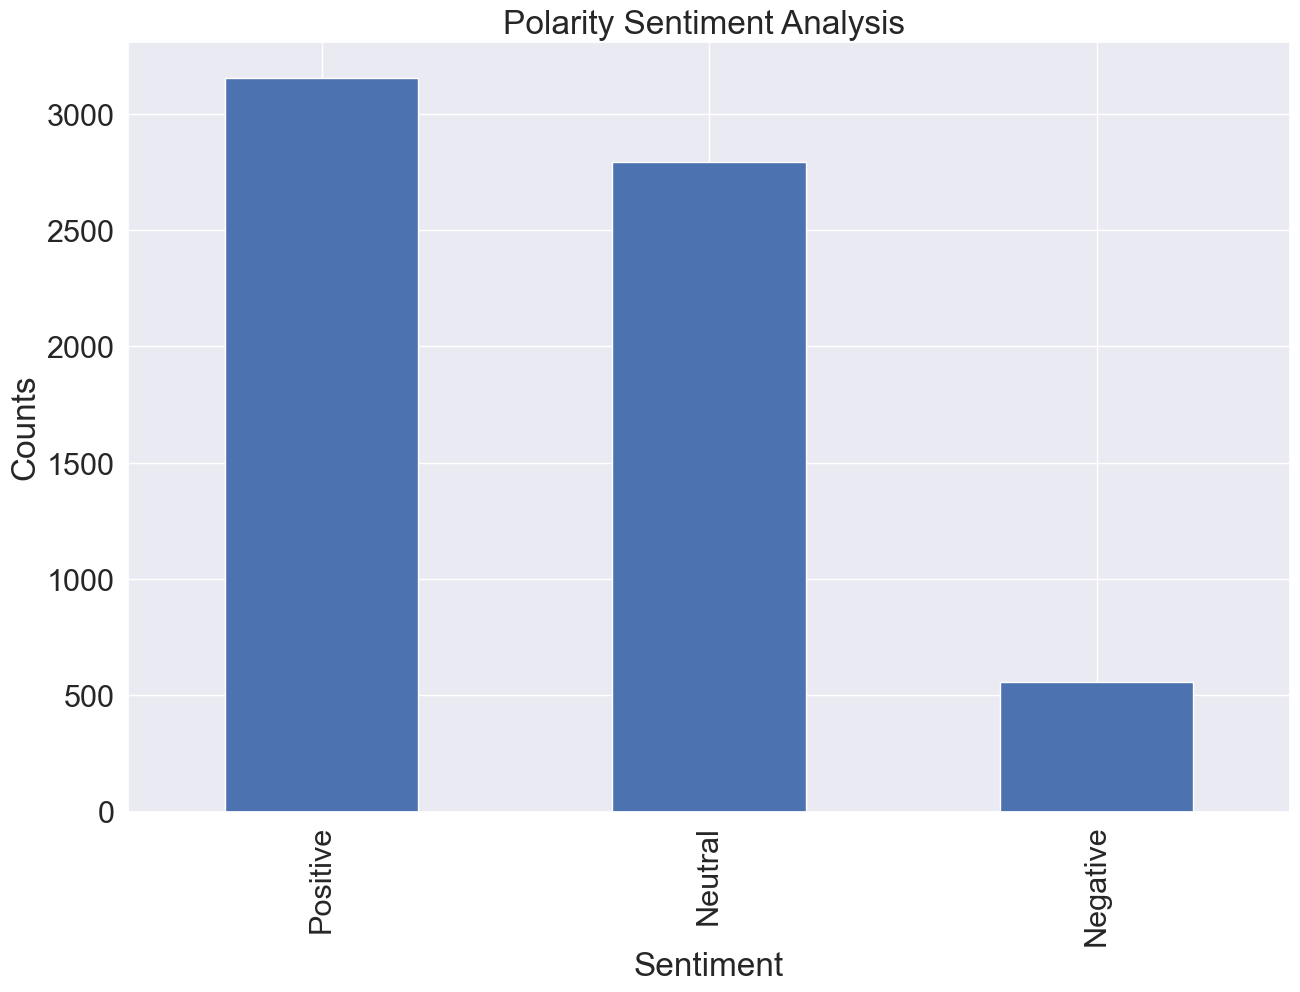

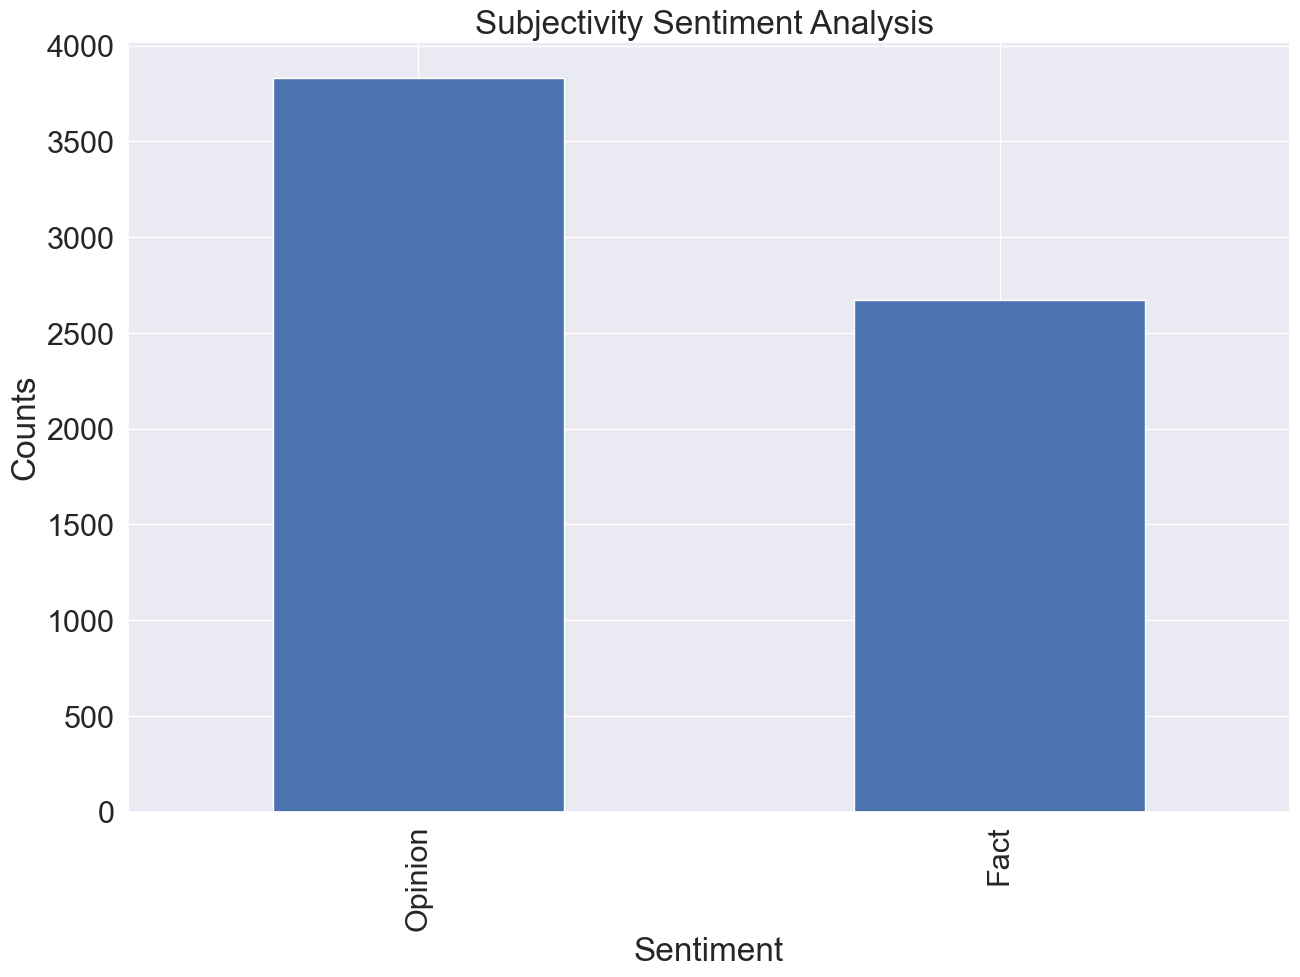

In [37]:
# todos
df_sent = df_comments
plot_SentimentAnalysis(df_sent, '')
plot_PolatiryAnalisys(df_sent, '')
plot_SubjectivityAnalysis(df_sent, '')

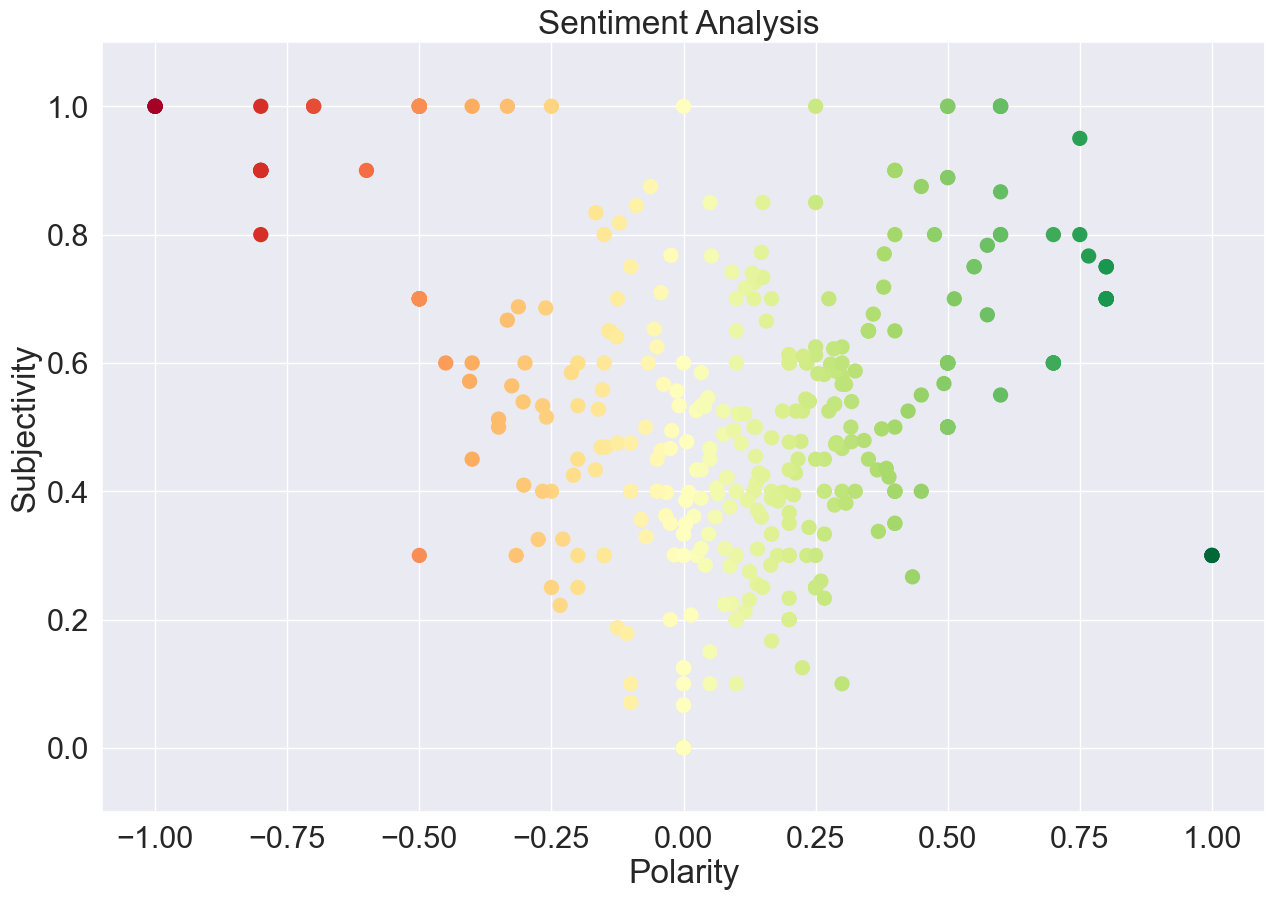

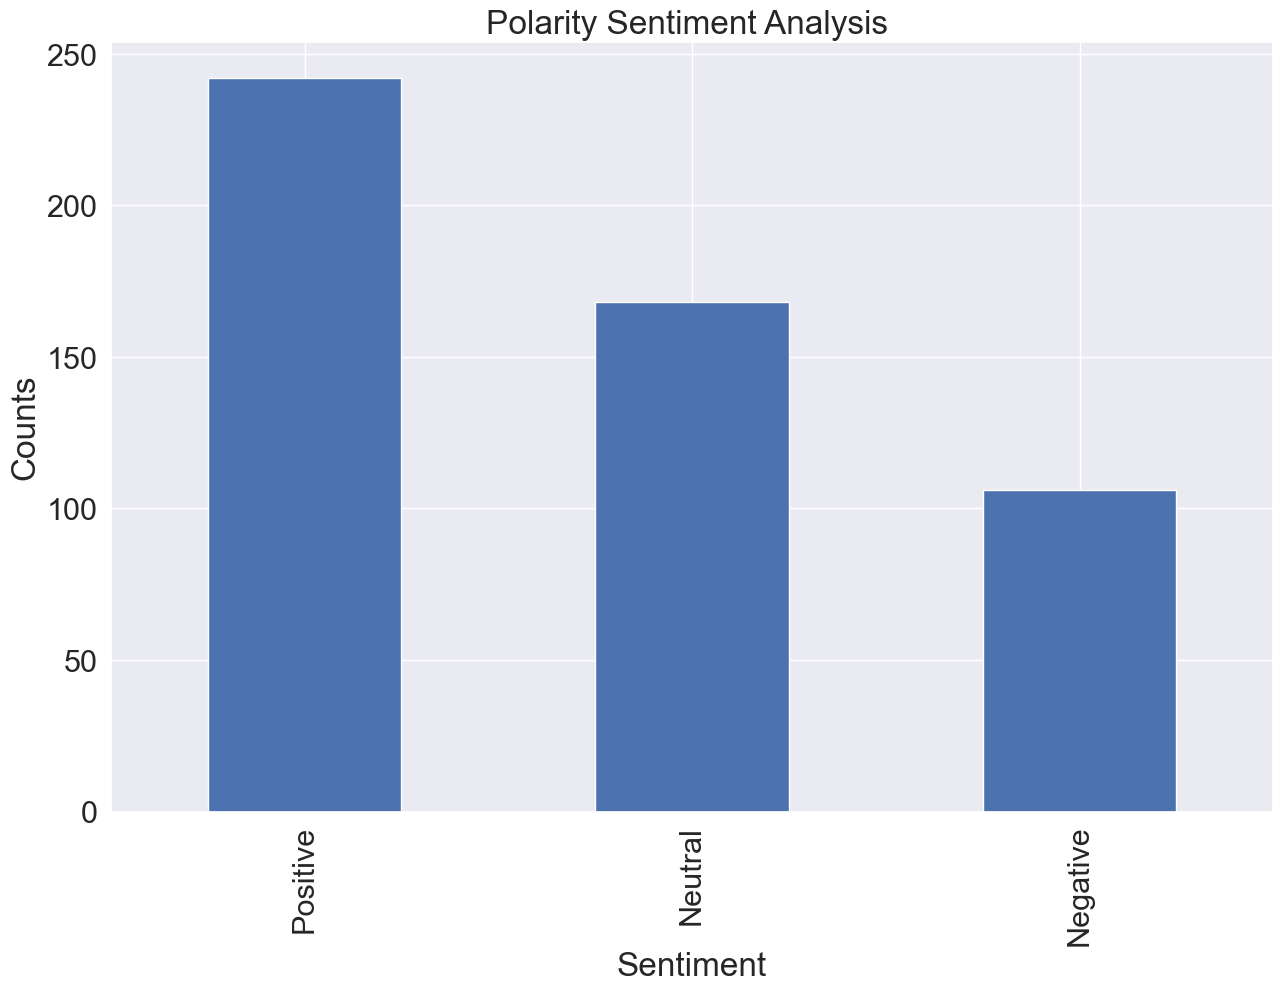

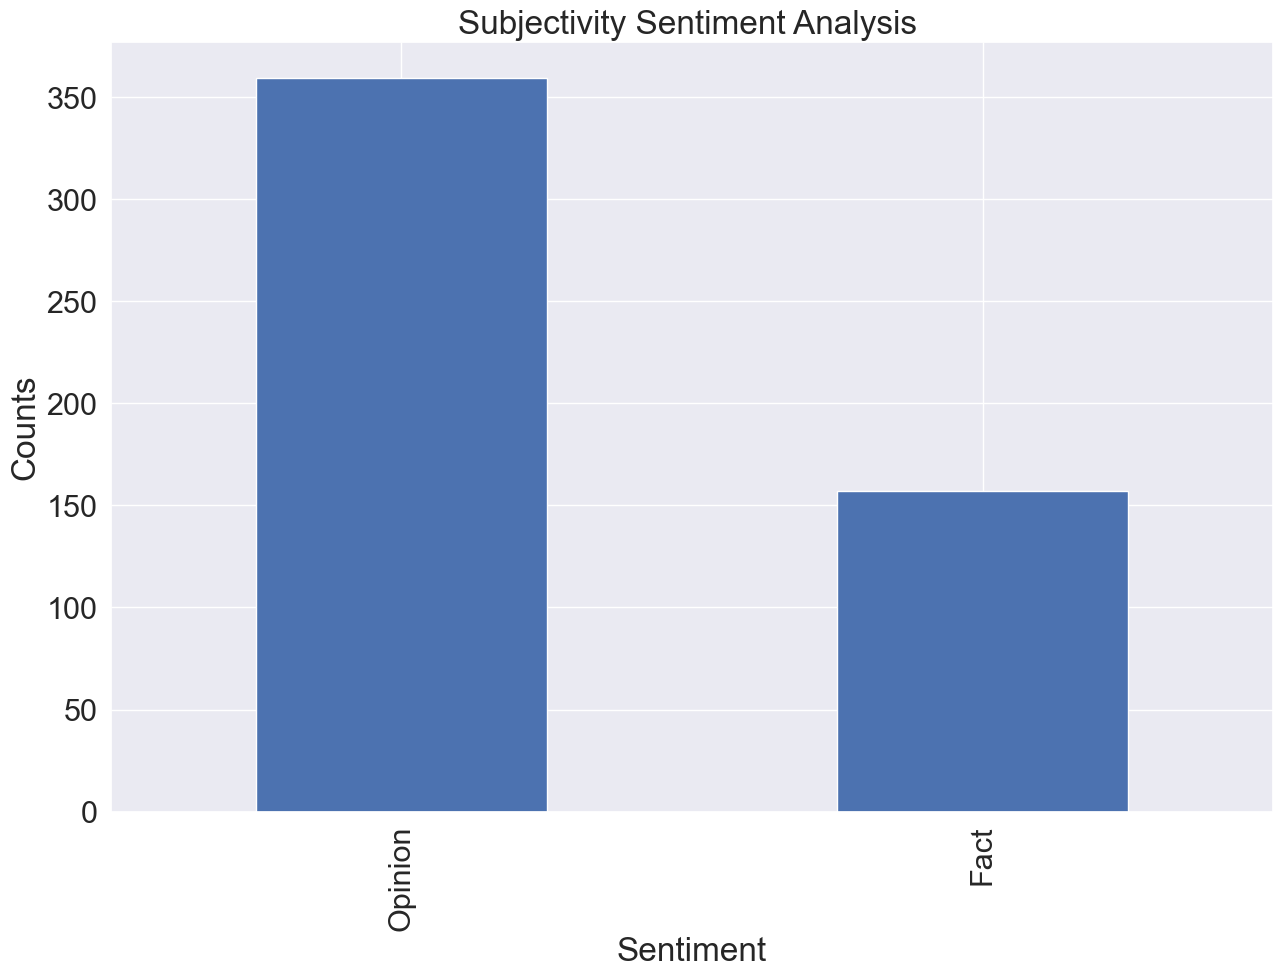

In [38]:
# gapkids
df_sent = df_comments[(df_comments['origin']=='youtube')]
plot_SentimentAnalysis(df_sent, '')
plot_PolatiryAnalisys(df_sent, '')
plot_SubjectivityAnalysis(df_sent, '')


### Topic Modelling (youtube)

In [39]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [40]:
df_comments['origin'].unique()

array(['youtube', 'instagram-gap', 'instagram-gapkidds'], dtype=object)

In [41]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list (only youtube)
#data = df_comments['cleaned_comments'].values.tolist()
data = df_comments[df_comments['origin']!='youtube']['cleaned_comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])





[['scammer', 'work', 'ordered', 'clothes', 'instead', 'ing', 'shipping', 'address', 'provided', 'magically', 'ked', 'ups', 'state', 'away', 'better']]


In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

num_topics = 7
# Build LDA model
# num_topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize= 10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#                                           alpha='symmetric',

print(lda_model.print_topics())

[(0, '0.039*"day" + 0.034*"save" + 0.034*"code" + 0.028*"say" + 0.027*"need" + 0.025*"brand" + 0.023*"school" + 0.022*"maybe" + 0.022*"let" + 0.022*"shop"'), (1, '0.105*"thank" + 0.045*"get" + 0.041*"good" + 0.038*"cool" + 0.029*"style" + 0.022*"wait" + 0.022*"follow" + 0.020*"see" + 0.019*"customer" + 0.016*"size"'), (2, '0.064*"beautiful" + 0.055*"check" + 0.043*"baby" + 0.039*"name" + 0.035*"make" + 0.035*"much" + 0.034*"girl" + 0.028*"guy" + 0.024*"sure" + 0.024*"product"'), (3, '0.280*"love" + 0.052*"great" + 0.041*"buy" + 0.039*"awesome" + 0.038*"outfit" + 0.037*"dress" + 0.024*"really" + 0.019*"perfect" + 0.017*"smile" + 0.017*"whole"'), (4, '0.105*"model" + 0.046*"little" + 0.041*"well" + 0.039*"know" + 0.038*"wear" + 0.032*"friend" + 0.025*"boy" + 0.024*"order" + 0.022*"interested" + 0.021*"wish"'), (5, '0.208*"gap" + 0.115*"look" + 0.093*"kid" + 0.044*"cash" + 0.042*"want" + 0.021*"amazing" + 0.020*"story" + 0.017*"modeling" + 0.017*"darling" + 0.016*"coupon"'), (6, '0.268*"c

In [44]:
lda_model.print_topics()


[(0,
  '0.039*"day" + 0.034*"save" + 0.034*"code" + 0.028*"say" + 0.027*"need" + 0.025*"brand" + 0.023*"school" + 0.022*"maybe" + 0.022*"let" + 0.022*"shop"'),
 (1,
  '0.105*"thank" + 0.045*"get" + 0.041*"good" + 0.038*"cool" + 0.029*"style" + 0.022*"wait" + 0.022*"follow" + 0.020*"see" + 0.019*"customer" + 0.016*"size"'),
 (2,
  '0.064*"beautiful" + 0.055*"check" + 0.043*"baby" + 0.039*"name" + 0.035*"make" + 0.035*"much" + 0.034*"girl" + 0.028*"guy" + 0.024*"sure" + 0.024*"product"'),
 (3,
  '0.280*"love" + 0.052*"great" + 0.041*"buy" + 0.039*"awesome" + 0.038*"outfit" + 0.037*"dress" + 0.024*"really" + 0.019*"perfect" + 0.017*"smile" + 0.017*"whole"'),
 (4,
  '0.105*"model" + 0.046*"little" + 0.041*"well" + 0.039*"know" + 0.038*"wear" + 0.032*"friend" + 0.025*"boy" + 0.024*"order" + 0.022*"interested" + 0.021*"wish"'),
 (5,
  '0.208*"gap" + 0.115*"look" + 0.093*"kid" + 0.044*"cash" + 0.042*"want" + 0.021*"amazing" + 0.020*"story" + 0.017*"modeling" + 0.017*"darling" + 0.016*"coupon"

In [45]:
# format topic sentences
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.7442,"model, little, well, know, wear, friend, boy, ...","[scammer, work, order, clothe, instead, shippi..."
1,1,4,0.7441,"model, little, well, know, wear, friend, boy, ...","[scammer, work, order, clothe, instead, shippi..."
2,2,6,0.1435,"cute, super, hope, adorable, luv, daughter, we...",[adl]
3,3,4,0.5714,"model, little, well, know, wear, friend, boy, ...",[model]
4,4,4,0.3810,"model, little, well, know, wear, friend, boy, ...","[nice, design]"
5,5,0,0.1429,"day, save, code, say, need, brand, school, may...",[]
6,6,5,0.8679,"gap, look, kid, cash, want, amazing, story, mo...","[want, tty, overprice, sweatshop, clothing, fa..."
7,7,1,0.6085,"thank, get, good, cool, style, wait, follow, s...","[happy, appreciate, powerful, caster, call, he..."
8,8,6,0.1437,"cute, super, hope, adorable, luv, daughter, we...",[adl]
9,9,6,0.9441,"cute, super, hope, adorable, luv, daughter, we...","[iyi, nler, anlayacak, birinin, bilgileri, dem..."


In [46]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9315,"day, save, code, say, need, brand, school, maybe, let, shop","[pay, grand, first, people, message, depressed, cu, feel, people, go, hard, time, stay_blessed]"
1,1,0.8775,"thank, get, good, cool, style, wait, follow, see, customer, size","[sorry_hear, see, option, available, hope_hear, soon]"
2,2,0.9012,"beautiful, check, baby, name, make, much, girl, guy, sure, product","[panie, donate, organization, support, racial, equality, much, contribute]"
3,3,0.8838,"love, great, buy, awesome, outfit, dress, really, perfect, smile, whole","[ai, mande, toujour, envoy, plusieur, mail, merci, pour, votre, aide]"
4,4,0.9037,"model, little, well, know, wear, friend, boy, order, interested, wish","[place, order, ff, event, entire, order, cancel, disappoint]"
5,5,0.8679,"gap, look, kid, cash, want, amazing, story, modeling, darling, coupon","[want, tty, overprice, sweatshop, clothing, fack, gap]"
6,6,0.9441,"cute, super, hope, adorable, luv, daughter, website, mom, take, excelente","[iyi, nler, anlayacak, birinin, bilgileri, deme, erisinde, gitsede, hesab, inanm, olay, bile, he..."


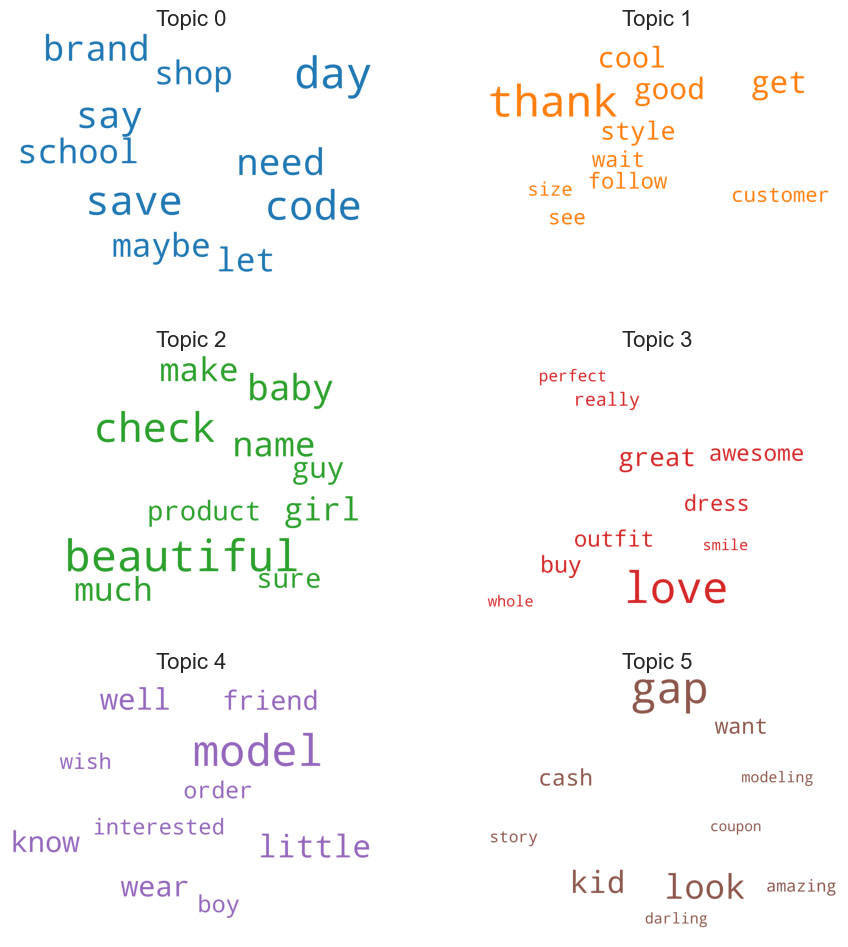

In [47]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots( int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [48]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.354929 -0.066713       1        1  23.320904
0     -0.043273  0.122918       2        1  16.052425
4     -0.073042  0.063586       3        1  15.231470
2     -0.088241  0.032379       4        1  12.897233
5      0.004405  0.112542       5        1  11.461488
3     -0.117245 -0.327026       6        1  10.932829
6     -0.037533  0.062315       7        1  10.103651, topic_info=        Term        Freq       Total Category  logprob  loglift
85      love  729.000000  729.000000  Default  30.0000  30.0000
73      cute  645.000000  645.000000  Default  29.0000  29.0000
19       gap  568.000000  568.000000  Default  28.0000  28.0000
48     thank  581.000000  581.000000  Default  27.0000  27.0000
14     model  379.000000  379.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
2085  course    7.706396    8.715392   Topic7  -5.7425   2.1692
3078   igual    7.432746    8.410800   Topic7  -5.7786   2.1687
421    right    6.885619    7.862411   Topic7  -5.8551   2.1596
1996      fy    8.827111   10.136712   Topic7  -5.6067   2.1539
1260   legit   17.742479   25.939957   Topic7  -4.9086   1.9125

[266 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
758       3  0.981887  absolutely
212       2  0.989050          ad
74        7  0.994132    adorable
1556      4  0.941597       adorb
1541      5  0.961605       adore
...     ...       ...         ...
3559      7  0.030372   worthless
1521      7  0.883521         yay
306       3  0.980809        year
1686      3  0.989188    year_old
1537      6  0.976520      yellow

[286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 6, 4, 7])

In [50]:
# commments by origin
df_comments.groupby(['origin'])['origin'].count()

origin
instagram-gap         1025
instagram-gapkidds    4961
youtube                516
Name: origin, dtype: int64

In [51]:
# gap
print('total posts: ', df_i_posts_gap['pk'].count())
print('total likes: ', df_i_posts_gap['like_count'].sum())
print('likes/posts: ', df_i_posts_gap['like_count'].sum()/df_i_posts_gap['pk'].count())

total posts:  223
total likes:  754560
likes/posts:  3383.677130044843


In [52]:
#gapkids
print('total posts: ', df_i_posts_gapkids['pk'].count())
print('total likes: ', df_i_posts_gapkids['like_count'].sum())
print('likes/posts: ', df_i_posts_gapkids['like_count'].sum()/df_i_posts_gapkids['pk'].count())


total posts:  716
total likes:  1152560
likes/posts:  1609.7206703910615
